In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('../data/secondary_data.csv', delimiter=';')
df.head(10)

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,p,15.26,x,g,o,f,e,NaN,w,16.95,...,s,y,w,u,w,t,g,NaN,d,w
1,p,16.60,x,g,o,f,e,NaN,w,17.99,...,s,y,w,u,w,t,g,NaN,d,u
2,p,14.07,x,g,o,f,e,NaN,w,17.80,...,s,y,w,u,w,t,g,NaN,d,w
3,p,14.17,f,h,e,f,e,NaN,w,15.77,...,s,y,w,u,w,t,p,NaN,d,w
4,p,14.64,x,h,o,f,e,NaN,w,16.53,...,s,y,w,u,w,t,p,NaN,d,w
5,p,15.34,x,g,o,f,e,NaN,w,17.84,...,s,y,w,u,w,t,p,NaN,d,u
6,p,14.85,f,h,o,f,e,NaN,w,17.71,...,s,y,w,u,w,t,g,NaN,d,w
7,p,14.86,x,h,e,f,e,NaN,w,17.03,...,s,y,w,u,w,t,p,NaN,d,u
8,p,12.85,f,g,o,f,e,NaN,w,17.27,...,s,y,w,u,w,t,p,NaN,d,a
9,p,13.55,f,g,e,f,e,NaN,w,16.04,...,s,y,w,u,w,t,p,NaN,d,w


In [4]:
df.shape

(61069, 21)

In [5]:
df.dtypes

class                    object
cap-diameter            float64
cap-shape                object
cap-surface              object
cap-color                object
does-bruise-or-bleed     object
gill-attachment          object
gill-spacing             object
gill-color               object
stem-height             float64
stem-width              float64
stem-root                object
stem-surface             object
stem-color               object
veil-type                object
veil-color               object
has-ring                 object
ring-type                object
spore-print-color        object
habitat                  object
season                   object
dtype: object

In [6]:
numerical = df.select_dtypes(include=["float64"]).columns.tolist()
categorical = df.select_dtypes(include=["object"]).columns.tolist()
categorical.remove("class") # Remove target variable

#### Class Distribution

In [7]:
df["class"].value_counts(normalize=True)

class
p    0.554913
e    0.445087
Name: proportion, dtype: float64

#### Check for missing values

In [8]:
pd.DataFrame({
    'dtype': df.dtypes,
    'missing': df.isnull().sum(),
    'missing_pct': (df.isnull().sum() / len(df) * 100).round(2)
})

,dtype,missing,missing_pct
class,object,0,0.00
cap-diameter,float64,0,0.00
cap-shape,object,0,0.00
cap-surface,object,14120,23.12
cap-color,object,0,0.00
does-bruise-or-bleed,object,0,0.00
gill-attachment,object,9884,16.18
gill-spacing,object,25063,41.04
gill-color,object,0,0.00
stem-height,float64,0,0.00


#### stem-root, veil-type, veil-color, spore-print-color have a major chunk of data missing. They are not going to be useful. I am going to remove them. I plan to treat missing values as a category as its own.

In [9]:
missing = ["cap-surface", "gill-attachment", "gill-spacing", "stem-surface", "ring-type"]

In [10]:
cols = ['stem-root', 'veil-type', 'veil-color', 'spore-print-color']
categorical = list(set(categorical) - set(cols))
df.drop(cols, inplace=True, axis=1)
df.fillna("unknown", inplace=True)

In [11]:
df[numerical].describe()

,cap-diameter,stem-height,stem-width
count,61069.000000,61069.000000,61069.000000
mean,6.733854,6.581538,12.149410
std,5.264845,3.370017,10.035955
min,0.380000,0.000000,0.000000
25%,3.480000,4.640000,5.210000
50%,5.860000,5.950000,10.190000
75%,8.540000,7.740000,16.570000
max,62.340000,33.920000,103.910000


#### Mean is greater than median for all the three variables which indicate skewness.

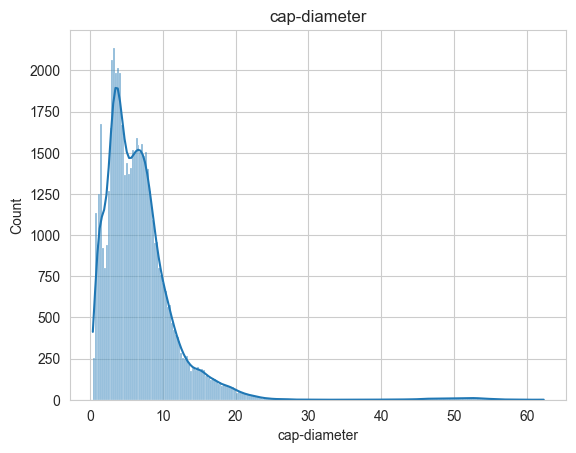

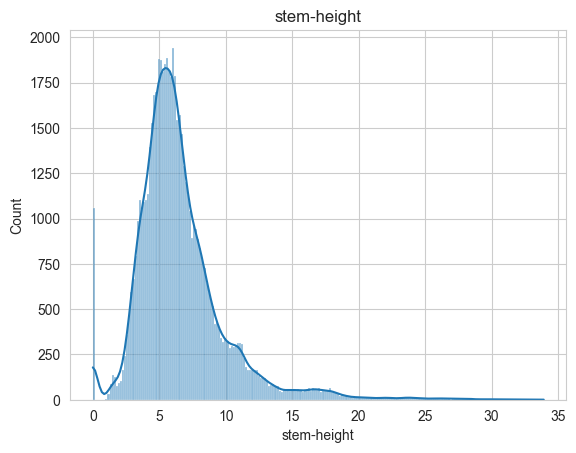

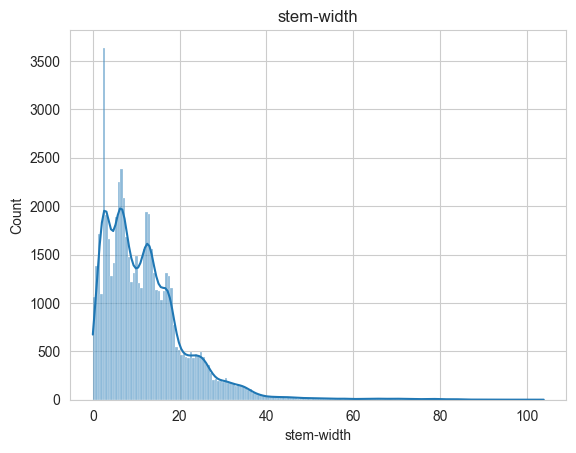

In [12]:
for c in numerical:
    sns.histplot(df[c], kde=True)
    plt.title(c)
    plt.show()


#### There is a long tail. Going to apply log transformation to handle the skewness.

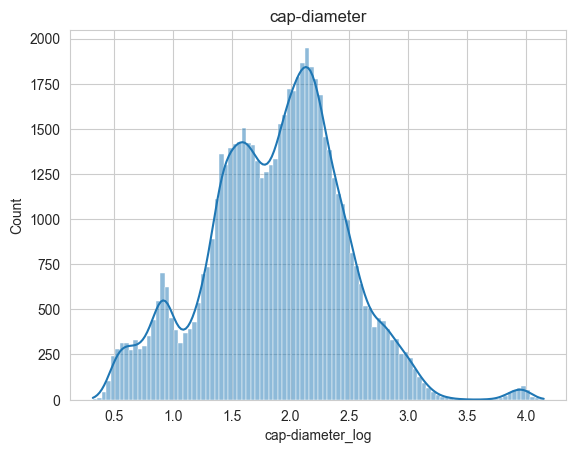

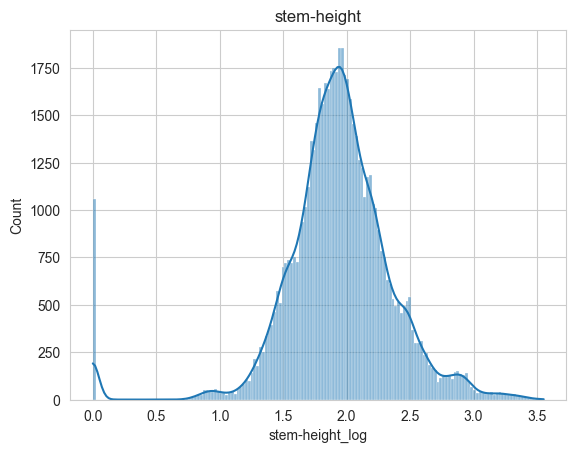

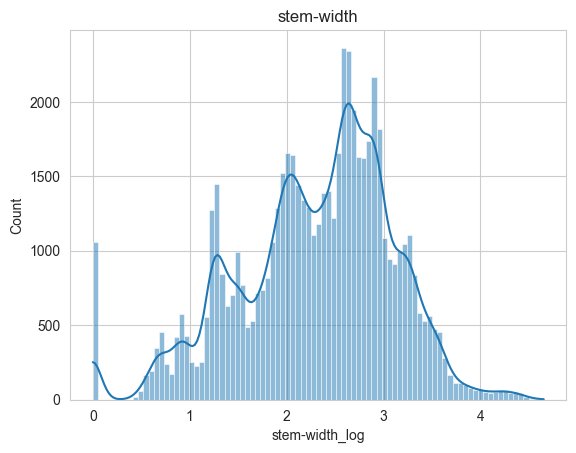

In [13]:
for col in numerical:
    df[col + '_log'] = np.log1p(df[col])

for c in numerical:
    sns.histplot(df[c + '_log'], kde=True)
    plt.title(c)
    plt.show()


#### stem-height now very much looks like a normal distribution. cap-diameter and stem-width looks a little bumpy. Maybe because different species of mushrooms comes in different sizes.

In [14]:
numerical_log = [col + '_log' for col in numerical]

In [15]:
df[numerical_log].corr()

,cap-diameter_log,stem-height_log,stem-width_log
cap-diameter_log,1.000000,0.467051,0.827303
stem-height_log,0.467051,1.000000,0.561462
stem-width_log,0.827303,0.561462,1.000000


cap-diameter and stem_width are highly correlated. Regularization should handle this.

#### Categorical variables

In [16]:
from sklearn.feature_selection import mutual_info_classif

X = df[categorical].apply(lambda col: col.astype('category').cat.codes)
mi = mutual_info_classif(X, df["class"])

mi_scores = sorted(zip(categorical, mi), key=lambda x: x[1], reverse=True)
mi_scores


[('stem-surface', np.float64(0.04718165753673831)),
 ('stem-color', np.float64(0.04570516608184949)),
 ('ring-type', np.float64(0.03306513243824316)),
 ('cap-color', np.float64(0.03221530504135495)),
 ('cap-surface', np.float64(0.030418535949740866)),
 ('gill-attachment', np.float64(0.027710757153325494)),
 ('cap-shape', np.float64(0.023868937080258723)),
 ('gill-color', np.float64(0.01820202900959833)),
 ('habitat', np.float64(0.016119680396224467)),
 ('season', np.float64(0.008395805421253177)),
 ('gill-spacing', np.float64(0.007096701302941044)),
 ('has-ring', np.float64(0.0027606250907261654)),
 ('does-bruise-or-bleed', np.float64(0.0006957296641372235))]

In [18]:
high_cat = ['stem-color', 'stem-surface', 'cap-surface', 'ring-type', 'cap-color']
med_cat = ['gill-attachment', 'cap-shape', 'gill-color', 'habitat']
low_cat = ['season', 'has-ring', 'gill-spacing', 'does-bruise-or-bleed']

#### Logistic Regression

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

In [20]:
def prepare_train(numerical_features, categorical_features):
    preprocess = ColumnTransformer(
        transformers=[
            ("num", "passthrough", numerical_features),
            ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_features),
        ]
    )

    log_reg = LogisticRegression(
    max_iter=1000,
    penalty="l2",        # default regularization (good with correlated features)
    solver="lbfgs",  # works for binary/multiclass
        random_state=42,
        C=10.0
)

    clf = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", log_reg),
    ]
)
    return clf

def evaluation(X_test, y_test, clf):
    # Predictions
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]  # for ROC AUC

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    print("ROC AUC:", roc_auc_score(y_test, y_proba))

#### With all features

In [21]:
numerical_features = numerical_log
categorical_features = categorical

X = df[numerical_features + categorical_features]
y = df["class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

clf = prepare_train(numerical_features, categorical_features)
clf.fit(X_train, y_train)
evaluation(X_test, y_test, clf)

Accuracy: 0.8248730964467005
              precision    recall  f1-score   support

           e       0.80      0.82      0.81      5436
           p       0.85      0.83      0.84      6778

    accuracy                           0.82     12214
   macro avg       0.82      0.82      0.82     12214
weighted avg       0.83      0.82      0.83     12214

ROC AUC: 0.8896973522309876


#### With high mutial information score features

In [22]:
numerical_features = numerical_log
categorical_features = high_cat

X = df[numerical_features + categorical_features]
y = df["class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

clf = prepare_train(numerical_features, categorical_features)
clf.fit(X_train, y_train)
evaluation(X_test, y_test, clf)

Accuracy: 0.77427542164729
              precision    recall  f1-score   support

           e       0.73      0.77      0.75      5436
           p       0.81      0.78      0.79      6778

    accuracy                           0.77     12214
   macro avg       0.77      0.77      0.77     12214
weighted avg       0.78      0.77      0.77     12214

ROC AUC: 0.8286063957082289


#### With High and Medium mutual information score features

In [23]:
numerical_features = numerical_log
categorical_features = high_cat + med_cat

X = df[numerical_features + categorical_features]
y = df["class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

clf = prepare_train(numerical_features, categorical_features)
clf.fit(X_train, y_train)
evaluation(X_test, y_test, clf)

Accuracy: 0.806533486163419
              precision    recall  f1-score   support

           e       0.78      0.80      0.79      5436
           p       0.83      0.82      0.82      6778

    accuracy                           0.81     12214
   macro avg       0.80      0.81      0.80     12214
weighted avg       0.81      0.81      0.81     12214

ROC AUC: 0.8760772092805121


In [24]:
from sklearn.model_selection import GridSearchCV

X = df[numerical_log + categorical]
y = df["class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

clf = prepare_train(numerical_log, categorical)

param_grid = {
    "model__C": [0.01, 0.1, 1.0, 10.0],
    "model__class_weight": [None, "balanced"],
}

grid = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=5,                # 5-fold stratified
    scoring="roc_auc",
    n_jobs=-1
)

grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)

Best params: {'model__C': 10.0, 'model__class_weight': None}


In [25]:
results = pd.DataFrame(grid.cv_results_)

results[
    ["params", "mean_test_score", "std_test_score", "rank_test_score"]
].sort_values("rank_test_score").head(10)

,params,mean_test_score,std_test_score,rank_test_score
6,"{'model__C': 10.0, 'model__class_weight': None}",0.889593,0.002960,1
4,"{'model__C': 1.0, 'model__class_weight': None}",0.889413,0.003105,2
7,"{'model__C': 10.0, 'model__class_weight': 'bal...",0.888883,0.003057,3
5,"{'model__C': 1.0, 'model__class_weight': 'bala...",0.888739,0.003280,4
2,"{'model__C': 0.1, 'model__class_weight': None}",0.886506,0.003839,5
3,"{'model__C': 0.1, 'model__class_weight': 'bala...",0.886050,0.003993,6
0,"{'model__C': 0.01, 'model__class_weight': None}",0.870166,0.005093,7
1,"{'model__C': 0.01, 'model__class_weight': 'bal...",0.869990,0.005288,8


#### Decision Tree

In [26]:
from sklearn.tree import DecisionTreeClassifier

In [27]:
def prepare_train(numerical_features, categorical_features):
    preprocess = ColumnTransformer(
        transformers=[
            ("num", "passthrough", numerical_features),
            ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_features),
        ]
    )

    model = DecisionTreeClassifier(random_state=42)

    clf = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", model),
    ]
)
    return clf

In [35]:
X = df[numerical_features + categorical_features]
y = df["class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

clf = prepare_train(numerical_features, categorical_features)
clf.fit(X_train, y_train)

print("Train")
evaluation(X_train, y_train, clf)

print("Test")
evaluation(X_test, y_test, clf)

Train
Accuracy: 1.0
              precision    recall  f1-score   support

           e       1.00      1.00      1.00     21745
           p       1.00      1.00      1.00     27110

    accuracy                           1.00     48855
   macro avg       1.00      1.00      1.00     48855
weighted avg       1.00      1.00      1.00     48855

ROC AUC: 1.0
Test
Accuracy: 0.999263140658261
              precision    recall  f1-score   support

           e       1.00      1.00      1.00      5436
           p       1.00      1.00      1.00      6778

    accuracy                           1.00     12214
   macro avg       1.00      1.00      1.00     12214
weighted avg       1.00      1.00      1.00     12214

ROC AUC: 0.9992450307242124


I think I found my model. Hehe.